# Lesson 0045 - Art Generation (III)
In this lesson, we pick up the Variational Autoencoder from [lesson 0044](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0044_mnist_variational_autoencoder.ipynb). We modify this autoencoder to create art like in [lesson 0043](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0043_art_generation_2.ipynb), which is why we start with stealing code from there.

In [1]:
import tensorflow as tf

tf.set_random_seed( 1234567890 )

print( tf.__version__ )

1.13.1


In [2]:
import numpy as np

np.random.seed( 1234567890 )

print( np.__version__ )

1.16.2


In [3]:
import matplotlib
import matplotlib.pyplot as plt

print( matplotlib.__version__ )

3.0.3


In [4]:
import keras
from keras import models
from keras import layers
from keras import callbacks
from keras.preprocessing.image import img_to_array as ita
from keras import backend as K



print( keras.__version__ )

2.2.4


Using TensorFlow backend.


In [5]:
from PIL import Image

print( Image.__version__ )

5.4.1


In [6]:
Image.MAX_IMAGE_PIXELS = None

Image.LOAD_TRUNCATED_IMAGES = True

In [7]:
import os

In [8]:
folder = 'C:\\Users\\rhopi\\OneDrive\\Desktop\\python dev\\github\\lesson_0042\\train_1\\'



number_of_images = 0



for img in os.listdir( folder ):
    
    number_of_images = number_of_images + 1
    
    
    
print( number_of_images )

2008


In [9]:
train = np.zeros( shape = [ 2008, 50, 50, 3 ], dtype = np.float32 )




i = 0




for img in os.listdir( folder ):
    
    path_img = folder + img
    
    current = Image.open( path_img )
    
    
    
    
    width, height = current.size
    
    
    
    
    if width > height:
        
        width_new = 50
        
        height_new = np.int( np.float( height ) / np.float( width ) * 50 )
        
    else:
        
        height_new = 50
        
        width_new = np.int( np.float( width ) / np.float( height ) * 50 )
        
        
    
    
    current = current.resize( ( width_new, height_new ), resample = Image.BILINEAR )
    
    
    
    
    insert = ita( current )
    
    
    
    
    train[ i, 0 : height_new, 0 : width_new, : ] = insert[ :, :, 0 : 3 ]
    
    
    
    
    i = i + 1
    
    current.close()

In [10]:
mean = np.mean( train )

std = np.std( train )



train = ( train - mean ) / std

Next, we adapt the definition of the __encoder__ to consider an output of $512$ dimensions. 

In [11]:
input_encoder = keras.engine.input_layer.Input( shape = ( 50, 50, 3, ) )

encoder_layer1 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_encoder )

encoder_layer2 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer1 )

encoder_layer3 = layers.MaxPooling2D()( encoder_layer2 )

encoder_layer4 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer3 )

encoder_layer5 = layers.Conv2D( 64, 5, activation = layers.LeakyReLU( alpha = 0.3 ) )( encoder_layer4 )

encoder_layer6 = layers.MaxPooling2D()( encoder_layer5 )

encoder_layer7 = layers.Flatten()( encoder_layer6 )

Instructions for updating:
Colocations handled automatically by placer.


C:\Users\rhopi\Anaconda3\lib\site-packages\keras\activations.py:211: UserWarning: Do not pass a layer instance (such as LeakyReLU) as the activation argument of another layer. Instead, advanced activation layers should be used just like any other layer in a model.
  identifier=identifier.__class__.__name__))


In [12]:
mu = layers.Dense( 512 )( encoder_layer7 )

log_var = layers.Dense( 512 )( encoder_layer7 )

In [13]:
def sampling( args ):
    
    m, var = args
    
    epsilon = K.random_normal( shape = K.shape( var, ), mean = 0, stddev = 1.0 )
    
    return m + K.exp( var / 2 ) * epsilon

In [14]:
encoder_output = layers.Lambda( sampling, output_shape = ( 512, ) )( [ mu, log_var ] )

encoder = keras.Model( input_encoder, encoder_output )

encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50, 50, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 46, 46, 64)   4864        input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 42, 42, 64)   102464      conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 21, 21, 64)   0           conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (

We change the __decoder__ from [lesson 0043](https://github.com/Mathhead/Lessons-in-Machine-Learning/blob/master/lesson_0043_art_generation_2.ipynb): __decoder_layer_1__ will be a dense layer of $625$ neurons, because we want to reshape this later into a $25*25*1$ tensor.<br>
Then, we use [UpSampling2D](https://keras.io/layers/convolutional/) to transform the $25*25*1$ image into a $50*50*?$ image.

In [15]:
input_decoder = keras.engine.input_layer.Input( shape = ( 512, ) )

decoder_layer1 = layers.Dense( 625, activation = layers.LeakyReLU( alpha = 0.3 ) )( input_decoder )

decoder_layer2 = layers.Reshape( ( 25, 25, 1, ) )( decoder_layer1 )

decoder_layer3 = layers.UpSampling2D()( decoder_layer2 )

decoder_layer4 = layers.Conv2D( 128, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer3 )

decoder_layer5 = layers.Conv2D( 3, 5, activation = layers.LeakyReLU( alpha = 0.3 ), padding = "SAME" )( decoder_layer4 )

decoder = keras.Model( input_decoder, decoder_layer5 )

decoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 625)               320625    
_________________________________________________________________
reshape_1 (Reshape)          (None, 25, 25, 1)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 50, 50, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 128)       3328      
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 50, 50, 3)         9603      
Total params: 333,556
Trainable params: 333,556
Non-trainable params: 0
_________________________________________________________________


In [16]:
variational_autoencoder = keras.Model( input_encoder, decoder( encoder( input_encoder ) ) )

variational_autoencoder.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 50, 50, 3)         0         
_________________________________________________________________
model_1 (Model)              (None, 512)               2672576   
_________________________________________________________________
model_2 (Model)              (None, 50, 50, 3)         333556    
Total params: 3,006,132
Trainable params: 3,006,132
Non-trainable params: 0
_________________________________________________________________


Since the reconstruction of the original image is important, we weigh the __mse__ with $100000$.

In [17]:
def my_loss( x, y ):
    
    loss1 = K.mean( K.square( x - y ) )
    
    loss2 = - 0.5 * K.sum( 1.0 + log_var - K.square( mu ) - K.exp( log_var ) )
    
    return 100000 * loss1 + loss2

In [18]:
variational_autoencoder.compile( optimizer = keras.optimizers.SGD( lr = 0.00000005, momentum = 0.9, decay = 0.00000005 / 50000.0,
                                                                  nesterov = False ), loss = my_loss, 
                                                                    metrics = None )

variational_autoencoder.fit( train, train, batch_size = 25, epochs = 50000 )

Epoch 1/50000
2008/2008 [==============================] - 5s 3ms/step - loss: 98635.6272
Epoch 2/50000
2008/2008 [==============================] - 2s 811us/step - loss: 97766.7610
Epoch 3/50000
2008/2008 [==============================] - 2s 812us/step - loss: 97451.6354
Epoch 4/50000
2008/2008 [==============================] - 2s 810us/step - loss: 97233.9482
Epoch 5/50000
2008/2008 [==============================] - 2s 808us/step - loss: 96982.9356
Epoch 6/50000
2008/2008 [==============================] - 2s 813us/step - loss: 96476.9731
Epoch 7/50000
2008/2008 [==============================] - 2s 815us/step - loss: 84995.5551
Epoch 8/50000
2008/2008 [==============================] - 2s 813us/step - loss: 64874.1375
Epoch 9/50000
2008/2008 [==============================] - 2s 811us/step - loss: 52307.1729
Epoch 10/50000
2008/2008 [==============================] - 2s 810us/step - loss: 45609.5785
Epoch 11/50000
2008/2008 [==============================] - 2s 810us/step - loss:

Now, we print the first $5$ training images and their reconstruction of the variational autoencoder.<br>
We notice, that in general, the images were reconstructed, but details got lost.

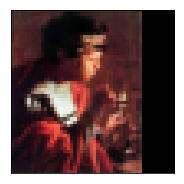

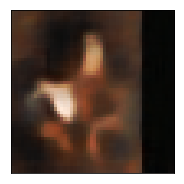

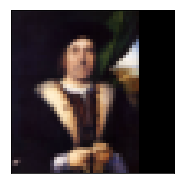

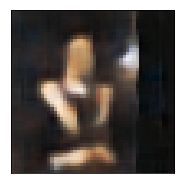

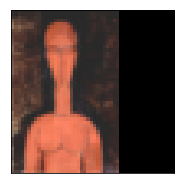

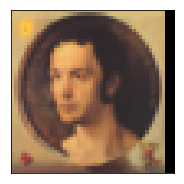

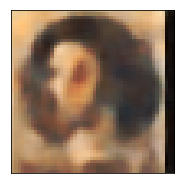

In [19]:
for i in range( 5 ):
    
    img = train[ i, :, :, : ]
    
    img = img * std + mean
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )    
    
    
    
    
    
    
    img = variational_autoencoder.predict( [ train[ i, :, :, : ].reshape( [ 1, 50, 50, 3 ] ) ] )[ 0 ]
    
    img = img * std + mean
        
        
        
    img = img - np.min( img )
        
    img = img / np.max( img )
        
    img = img * 255
        
    img = np.round( img )
        
    img = np.int32( img )
        
        
        
        
    plt.figure( figsize = ( 3, 3 ) )

    plt.imshow( img )

    plt.xticks( [] )

    plt.yticks( [] )

Next, we predict the output of the __encoder__ for each training image. We use these predictions to compute the mean and the standard deviation of each of the $512$ dimensions of the output of the __encoder__.

In [20]:
encoded = np.zeros( shape = [ 2008, 512 ] )

mu_trained = np.zeros( shape = [ 512 ] )

std_trained = np.zeros( shape = [ 512 ] )





for i in range( 2008 ):
    
    encoded[ i, : ] = encoder.predict( train[ i : i + 1, :, :, : ] )
    
    
    
    
for i in range( 512 ):
    
    mu_trained[ i ] = np.mean( encoded[ :, i ] )
    
    std_trained[ i ] = np.std( encoded[ :, i ] )

Now, we use these means and standard deviations to create random vectors, and we use these random vectors as input of the __decoder__ to generate images.

In [21]:
plotmat = np.zeros( shape = [ 250, 250, 3 ] )

for i in range( 5 ):
    
    for j in range( 5 ):
        
        x_left = i * 50
        
        x_right = x_left + 50
        
        y_top = j * 50
        
        y_bottom = y_top + 50
        
        random_input = np.random.normal( loc = mu_trained, scale = std_trained )
        
        random_input = random_input.reshape( [ 1, 512 ] )
        
        image = decoder.predict( random_input )[ 0, :, :, : ]
        
        image = image - np.min( image )
        
        image = image / np.max( image )
        
        plotmat[ x_left : x_right, y_top : y_bottom, : ] = image
        

        
        
        
        
plt.figure( 1, figsize = ( 15, 15 ) )      
        
plt.imshow( plotmat, cmap = "rainbow" )

plt.xticks( [ ] )

plt.yticks( [ ] )  

([], <a list of 0 Text yticklabel objects>)